<a href="https://colab.research.google.com/github/JaredHoang/test/blob/main/Pancreatic_Cancer_Classification_and_Exploring_the_Black_Box_with_Lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Getting environment info (output cleared to save space, but saved in a file called "Environment_Requirements")
# ! pip freeze

In [ ]:
# Installing Lime
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=24f0ed88cfccc110332ab9a7c14c193a92daa7ee1a6dedaeea594d5410684649
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Set random state for numpy operations
from numpy.random import seed
seed(2)
# Set random state for tensorflow operations
from tensorflow.random import set_seed
set_seed(3)
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import cv2
import PIL
# Importing libraries for model interpretability 
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers import scikit_image
from sklearn.utils import check_random_state
import copy
from functools import partial
import scipy as sp
from sklearn.linear_model import Ridge
from lime.wrappers.scikit_image import SegmentationAlgorithm

## **Functions**

In [ ]:
# Defining a function that will freeze all layers in a pretrained and original network
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Freeze_Pretrained_Base(pretrain, model):
    
    '''This function will freeze all layers in a pretrained and original network
      pretrain: refers to any instantiated pretrained network
      model: the name of the model you are adding the pretrained network to
    '''
    pretrain.trainable = False
    for layer in model.layers:
        print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

In [ ]:
# Re-freezing everything except for the last layer of the pretrained CNN
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Unfreeze_Layers(pretrain, layer_list):
    '''This function takes an instantiated pretrained neural network and a list containing layers to be frozen,
    and freezes those layers in the pretrained neural network.
    
    pretrain: refers to the instantiated pretrained neural network
    layer_list: refers to the list of layers to be frozen in the instantiated pretrained neural network.'''

    pretrain.trainable = True
    for layer in  pretrain.layers:
        if layer.name in layer_list:
            layer.trainable = True
        else:
            layer.trainable = False
        
    for layer in pretrain.layers:
        print(layer.name, layer.trainable)
    print(len(pretrain.trainable_weights))

In [ ]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
def print_metrics(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [ ]:
# I modified this function slightly from the one found on: 
# https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb

def network_matrix(model_scores):
    """
    Plots a confusion matrix using the scores that come from evaluating a 
    neural network model using either testing or validation data
   
  
    Parameters:
    model_scores = load_model('model_name.h5').evaluate_generator(test/val_generator) 
  
    Returns:
    confusion matrix
    """
    tn = np.round((model_scores[5])/(model_scores[5] + model_scores[6]), 2)
    fn = np.round((model_scores[7])/(model_scores[7] + model_scores[4]), 2)
    fp = np.round((model_scores[6])/(model_scores[6] + model_scores[5]), 2)
    tp = np.round((model_scores[4])/(model_scores[4] + model_scores[7]), 2)
    
    
    conf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots(figsize=(10, 8))
    heat = sns.heatmap(conf, annot=True, fmt='g', ax=ax )
    heat.set_xticklabels(['Cancer', 'Normal'], fontsize=15)
    heat.set_yticklabels(['Cancer', 'Normal'], fontsize=15)
    plt.ylabel('Predicted Label',fontsize=18)
    plt.xlabel('True Label', fontsize=18)

In [ ]:
def print_metrics_confusionmatrix(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  network_matrix(final_scores)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [ ]:
def ImageLabelsLime(img, img_idx, exp_num, lab_num, true_label, pred_label):

  '''
  img = numpy array of image you want to explore with LIME
  img_idx = the index of the image you want to explore with LIME (assuming that the index numbers of the incorrectly labelled images are in a list)
  exp_num = the instantiated instance of LimeExplainer that you will use to explain this image
  lab_num = the number of labels you want for the "top_labels" argument of the ".explain_instance" method
   '''
  
  
  image = img

  explanation_num = exp_num.explain_instance(val_img[img_idx].astype('double'),
                                         best_model.predict, 
                                         top_labels=lab_num,
                                         hide_color=0,
                                         num_samples=1000)
  temp_num, mask_num = explanation_num.get_image_and_mask(explanation_num.top_labels[0],
                                                       positive_only=False, num_features=10,
                                                       hide_rest=False)
  lime_graph = mark_boundaries(temp_num / 2 + 0.5, mask_num)
  
  plt.subplot(1, 2, 1)
  plt.imshow(image)
    
  plt.subplot(1, 2, 2)
  plt.imshow(lime_graph)

  plt.tight_layout()
  plt.show()

  print(f'Correct Label: {true_label}')
  print(f'Predicted Label: {pred_label}')

In [ ]:
# Retrieve the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import libraries
import zipfile
import os
# Load the data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/pancreatic_cancer_images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') # Takes out files and puts them into the /tmp folder
zip_ref.close()

In [ ]:
# Specify the train and test file paths
base_direc = '/tmp/pancreatic_cancer_images'
train_direc = os.path.join(base_direc, 'Training')
test_direc = os.path.join(base_direc, 'Testing')

In [ ]:
# Code structure from https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb
# Set up ImageDataGenerator
train_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,                           
                                   brightness_range=([0.6, 1.5]),
                                   horizontal_flip=True,
                                   validation_split=0.06) # this will set aside a part of training set for validation data
test_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,
                                   brightness_range=([0.6,1.5]),
                                   horizontal_flip=True)
# Bring the data in
train_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                    classes={'no_cancer':0,
                                            'cancer':1},
                                    target_size=(200,200),
                                    batch_size=2699, # Number of images in training set
                                    seed=42,
                                    class_mode='binary',
                                    subset='training')

test_generator = test_imagegen.flow_from_directory(
                                    test_direc,
                                     classes={'no_cancer':0,
                                            'cancer':1},
                                    target_size=(200,200),
                                    batch_size=394, # Number of Images in testing set
                                    seed=42,
                                    class_mode='binary')

val_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                     classes={'no_cancer':0,
                                            'cancer':1},
                                    target_size=(200,200),
                                    batch_size=171, # Number of images in validation set
                                    seed=42,
                                    class_mode='binary',
                                    subset='validation')

Found 1624 images belonging to 2 classes.
Found 926 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [ ]:
# Creating variables to contain image vectors and labels for training images
train_img, train_lab = next(train_generator)

In [ ]:
# Creating variables to contain image vectors and labels for testing images
test_img, test_lab = next(test_generator)

In [ ]:
# Creating variables to contain image vectors and labels for validation images
val_img, val_lab = next(val_generator)

## **Final Model (Uses the Pre-Trained VGG-19 Weights)**

In [ ]:
# Instantiating the pretrained VGG-19 model
from keras.applications.vgg19 import VGG19
cnn_vgg = VGG19(weights='imagenet',
               include_top=False,
               input_shape=(200,200,3))

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
pre_drop = keras.Sequential()
pre_drop.add(cnn_vgg)
pre_drop.add(layers.Flatten())
pre_drop.add(layers.Dense(128, activation='relu'))
pre_drop.add(layers.Dropout(0.4))
pre_drop.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Freezing all layers in pretrained VGG-19 network
Freeze_Pretrained_Base(cnn_vgg, pre_drop)

vgg19 False
flatten True
dense True
dropout True
dense_1 True
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre3 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='jan_pre3_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Compiling and fitting the model
pre_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

pre_drop_results = pre_drop.fit(x=train_img, y=train_lab,
                                steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                epochs=20,
                                callbacks= early_stop_pre3,
                                validation_data=(test_img, test_lab),
                                validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 31s 214ms/step - loss: 0.1265 - acc: 0.9572 - recall: 0.9551 - precision: 0.9551 - true_positives: 765.0000 - true_negatives: 847.0000 - false_positives: 36.0000 - false_negatives: 36.0000 - val_loss: 0.8438 - val_acc: 0.8274 - val_recall: 0.6731 - val_precision: 1.0000 - val_true_positives: 140.0000 - val_true_negatives: 186.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 68.0000
Epoch 2/20
85/85 [==============================] - 12s 143ms/step - loss: 0.0202 - acc: 0.9947 - recall: 0.9926 - precision: 0.9963 - true_positives: 802.0000 - true_negatives: 873.0000 - false_positives: 3.0000 - false_negatives: 6.0000 - val_loss: 0.0960 - val_acc: 0.9645 - val_recall: 0.9375 - val_precision: 0.9949 - val_true_positives: 195.0000 - val_true_negatives: 185.0000 - val_false_positives: 1.0000 - val_false_negatives: 13.0000
Epoch 3/20
85/85 [==============================] - 12s 141ms/step - loss: 0.0078 - acc: 0.9970 - recall: 

<ipython-input-9-5cc183a73fbb>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  final_scores = superior_model.evaluate_generator(generator)


Val Loss: 0.0004272770893294364
Val Accuracy: 1.0
Val Recall: 1.0
Val Precision: 1.0
Val True Positives: 49.0
Val True Negatives: 54.0
Val False Positives: 0.0
Val False Negatives: 0.0


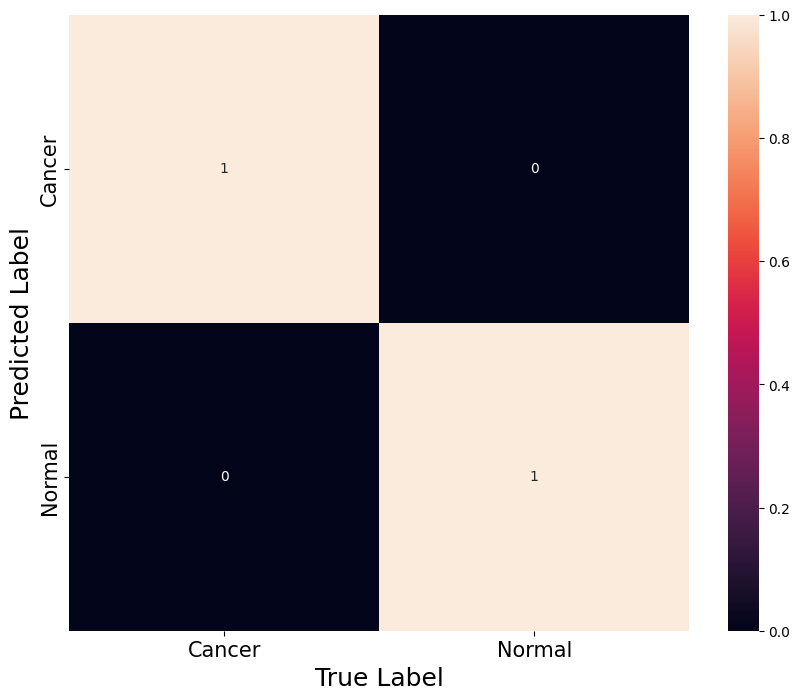

In [ ]:
print_metrics_confusionmatrix('jan_pre3_best_model.h5', val_generator, 'Val')

## **Digging in to Model Interpretability**

In [ ]:
best_model = load_model('/content/jan_pre3_best_model.h5')

In [ ]:
# Predictions for Validation data
val_preds_raw = best_model.predict(val_img)
val_preds = (val_preds_raw > 0.5).astype('int32')


4/4 [==============================] - 5s 484ms/step


In [ ]:
# Predictions for Training data
train_preds_raw = best_model.predict(train_img)
train_preds = (train_preds_raw > 0.5).astype('int32')

51/51 [==============================] - 10s 190ms/step


In [ ]:
val_lab = val_lab.astype('int32')
train_lab = train_lab.astype('int32')


In [ ]:
# getting the indices of the correctly and incorrectly labelled validation images

right = [i for i in range(len(val_img)) if val_preds[i] == val_lab[i]]
wrong = [i for i in range(len(val_img)) if val_preds[i] != val_lab[i]]
wrong

[]

In [ ]:
cancer_idxs = [i for i in range(len(val_img)) if val_lab[i] == 1]
normal_idxs = [i for i in range(len(val_img)) if val_lab[i] == 0]
cancer_idxs

[1,
 2,
 6,
 12,
 13,
 14,
 16,
 20,
 23,
 25,
 27,
 30,
 32,
 33,
 35,
 37,
 38,
 41,
 45,
 48,
 50,
 58,
 60,
 62,
 63,
 64,
 65,
 67,
 69,
 70,
 71,
 72,
 74,
 76,
 77,
 78,
 80,
 81,
 82,
 83,
 91,
 92,
 93,
 94,
 95,
 97,
 98,
 100,
 102]

In [ ]:
images = [val_img[0], val_img[55], val_img[7], val_img[99], train_img[2], train_img[13]]
titles = ['ectopic', 'annular', 'ectopic', 'annular','annular', 'ectopic']

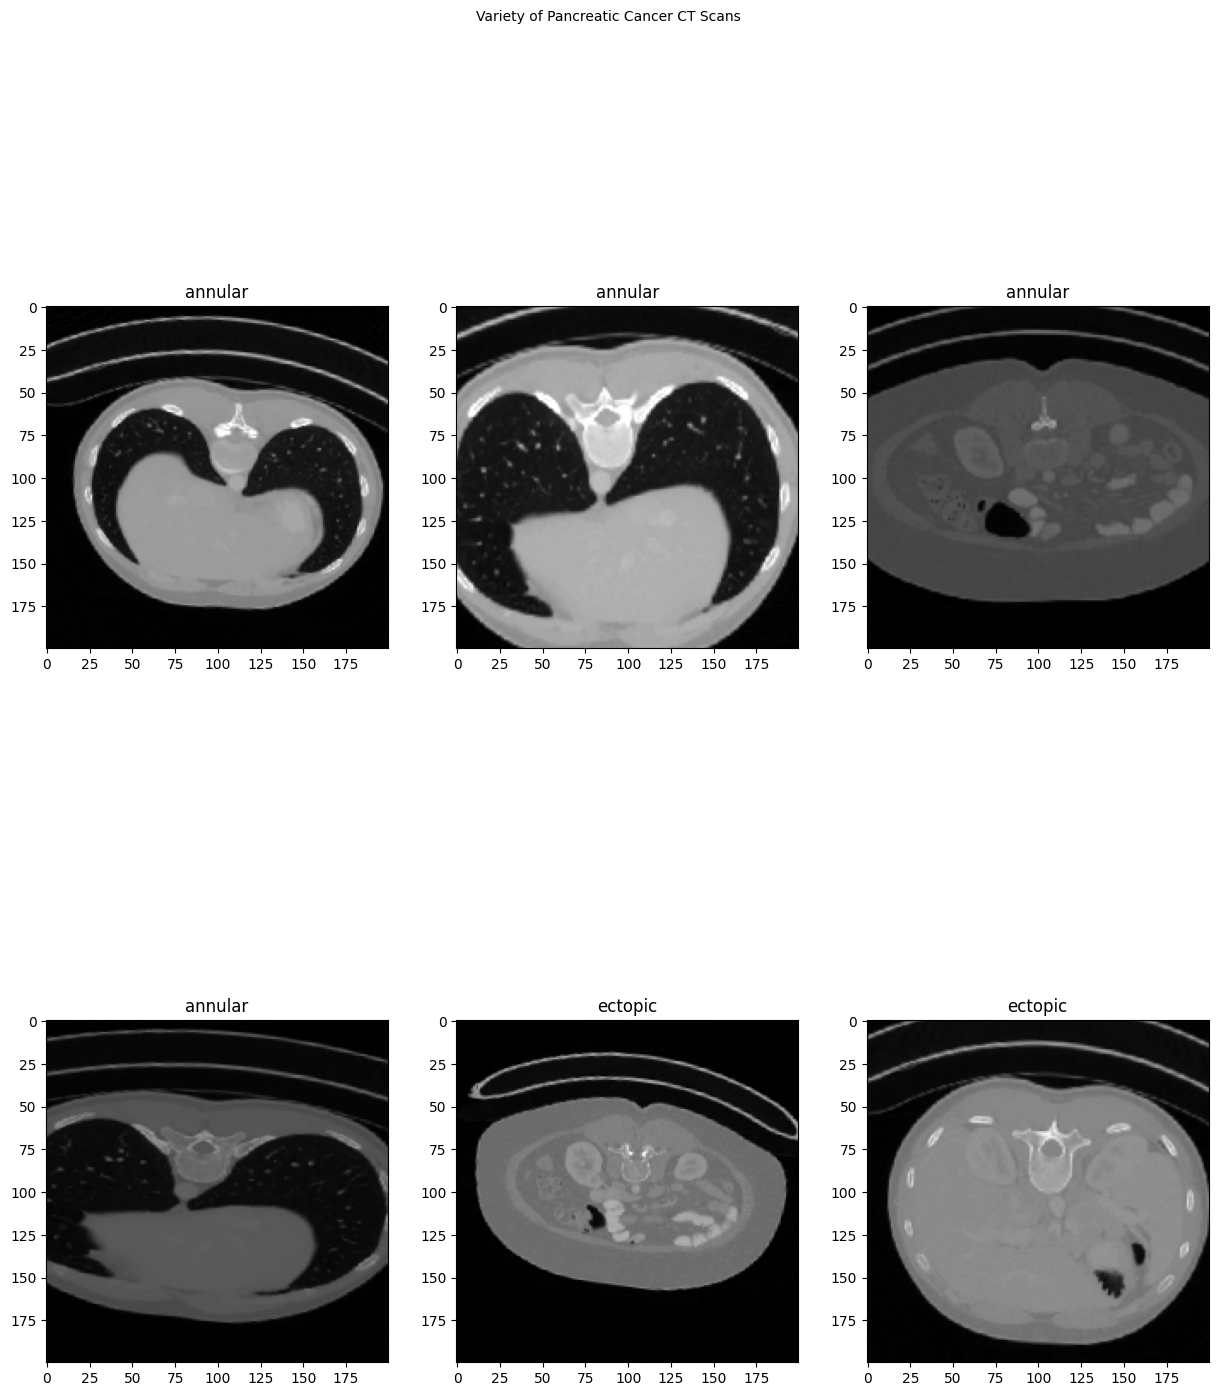

In [ ]:
# Some of code structure from https://stackoverflow.com/questions/48435229/how-to-plot-a-list-of-image-in-loop-using-matplotlib/48435411
fig, axes = plt.subplots(2, 3, figsize=(15, 17))
rows = 2

for num, x in enumerate(images):
    
    ax = axes[num // 3, num % 3]
    ax.imshow(x)
    axes[num//3, num%3].set_title('annular')
axes[1,1].set_title('ectopic')
axes[1,2].set_title('ectopic');
    
    

fig.suptitle('Variety of Pancreatic Cancer CT Scans',fontsize = 10)
plt.show()

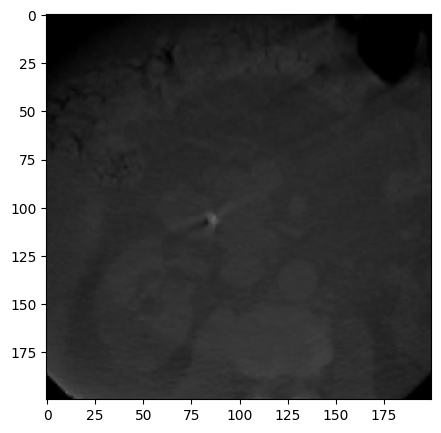

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(val_img[30])

In [ ]:
exp1 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


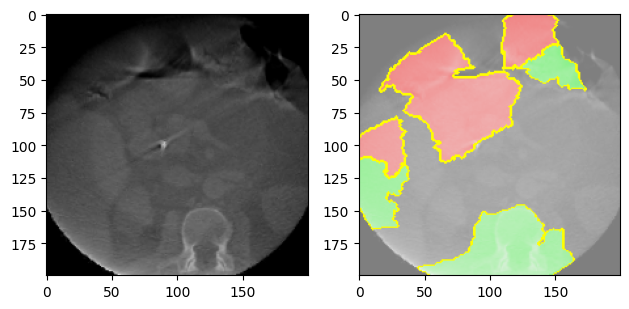

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[64], 64, exp1, 3, val_lab[64], val_preds[64])

In [ ]:
exp2 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


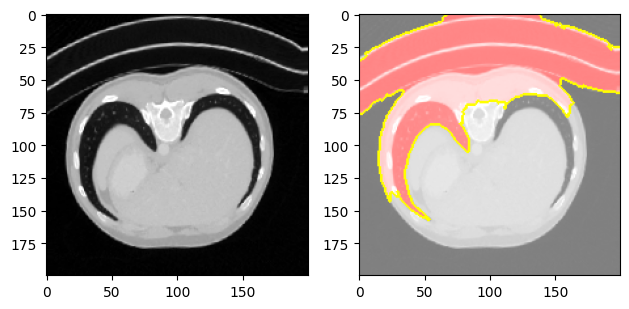

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[68], 68, exp2, 3, val_lab[68], val_preds[68])

In [ ]:
exp3 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


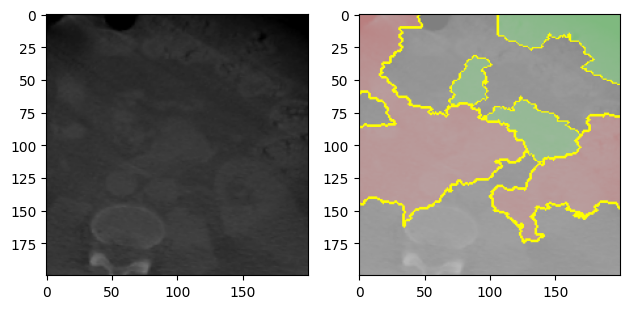

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[69], 69, exp3, 3, val_lab[69], val_preds[69])

The parts of the image that LIME labels as contributing to high and low probabilities of being labelled as the predicted class appear to be fairly random in this MRI.

In [ ]:
exp4 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


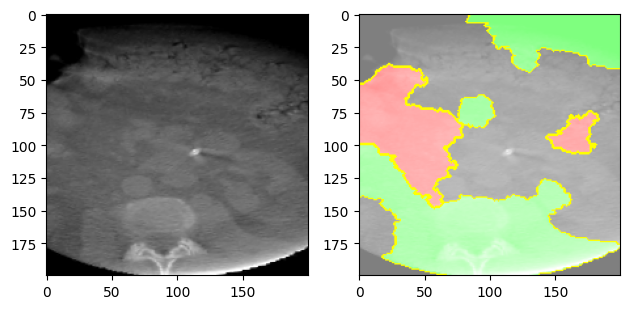

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[72], 72, exp4, 3, val_lab[72], val_preds[72])

In this image, the LIME identifies the eye region as contributing to a high probability that the MRI is misclassified as containing a tumor. This is probably because tumors can also appear in MRIs as a large mass with a white ring and dark center, which is exactly what the eyes look like.

In [ ]:
exp6 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


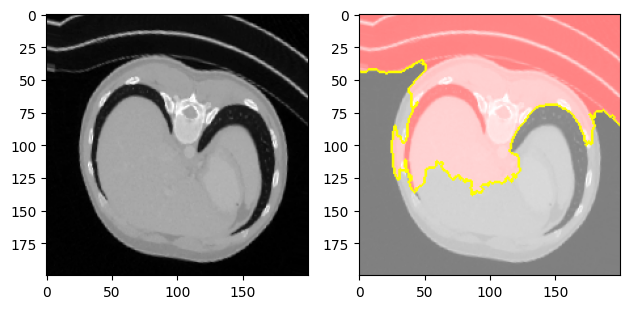

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[101], 101, exp6, 3, val_lab[101], val_preds[101])

In [ ]:
exp7 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


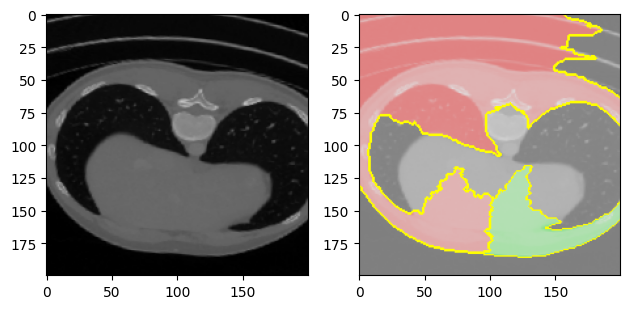

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[53], 53, exp7, 3, val_lab[53], val_preds[53])

In this image, LIME predicted the eyes as having a high probabilty of contributing to the image being misclassified as containing a tumor. Oftentimes tumors appear in MRIs as large white masses, so perhaps this is what the model is picking up on, and why it incorrectly labels this image.

In [ ]:
exp8 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


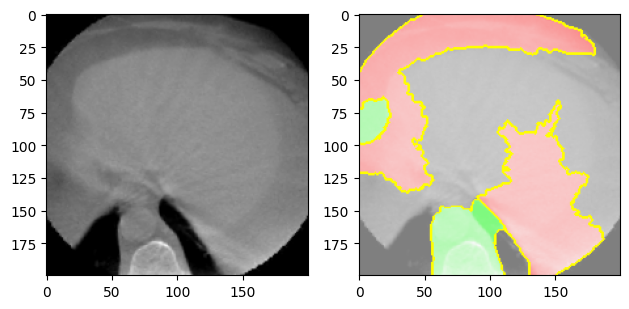

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[65], 65, exp8, 3, val_lab[65], val_preds[65])

The parts of the image that LIME labels as contributing to high and low probabilities of being labelled as the predicted class appear to be fairly random in this MRI.

## **Lime: Images with Tumors**

In [ ]:
exp9 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


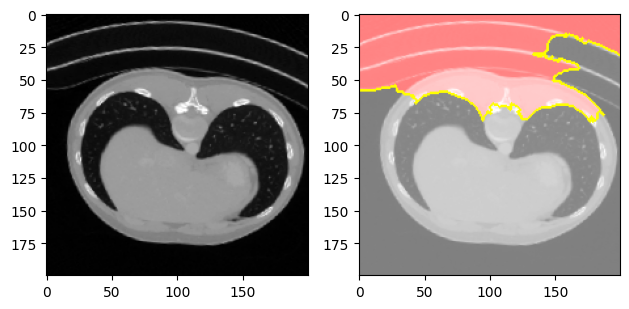

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[0], 0, exp9, 3, val_lab[0], val_preds[0])

In this image, LIME correctly identifies the tumor as contributing to a high probability that the image will be classified as containing a tumor. The tumor is an area of high black and white contrast with lots of edges to detect, so it makes sense that the model is picking up on this.

In [ ]:
exp10 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


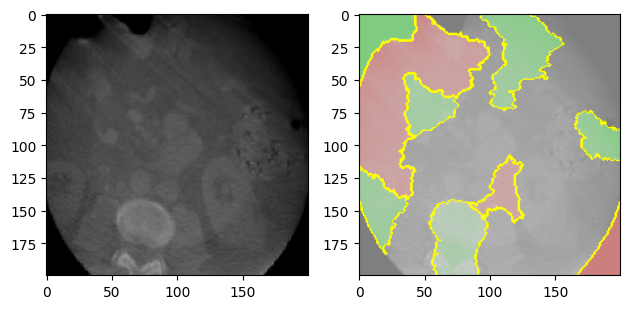

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[1], 1, exp10, 3, val_lab[1], val_preds[1])

In this image, LIME identifies part of the tumorous region as contributing to the lowest probability of the image being classified as containing a tumor. It looks as though a small sliver of the tumorous region may be in on of the regions of highest proobability of MRI being classified as having a tumor, but it is hard to tell. However, it still predicted the correct class, but it may have gotten the correct prediction for the wrong reasons.

In [ ]:
exp11 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


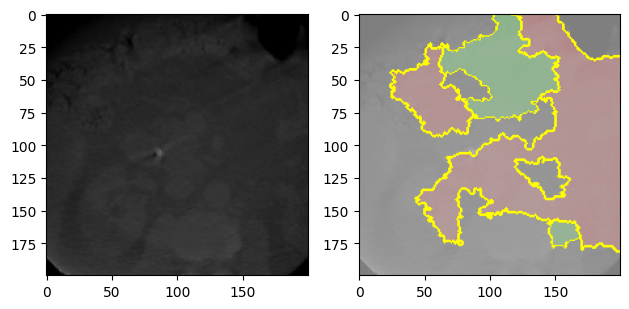

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[30], 30, exp11, 3, val_lab[30], val_preds[30])

In this image, LIME correctly identifies the tumor as contributing to a high probability that the image will be classified as containing a tumor. This tumor has a white outline and gray/black inside, and it is interesting to note that the eye region is also being identified as contributing positively to the tumor prediction. It appears so similar to the tumor, as it is a dark region surrounded by a white circular structure. LIME is showing us that the model has been trained to pick up on this kind of structure.

In [ ]:
exp12 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


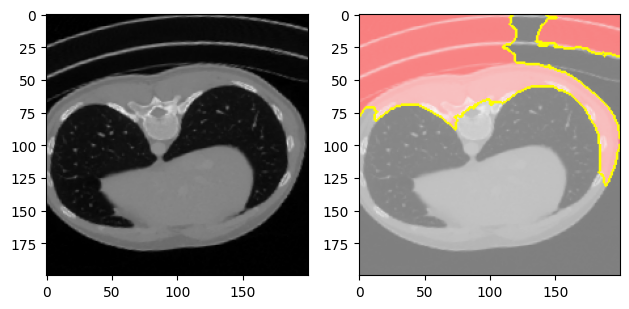

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[40], 40, exp12, 3, val_lab[40], val_preds[40])

In [ ]:
exp13 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


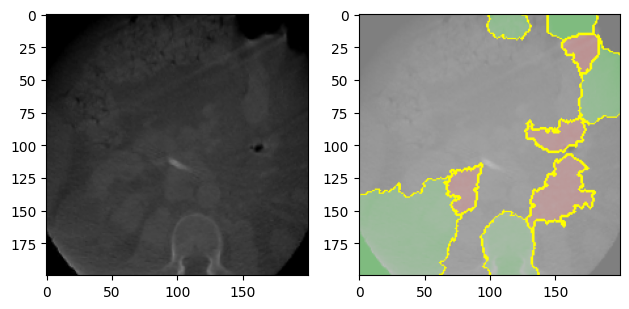

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[50], 50, exp13, 3, val_lab[50], val_preds[50])

In [ ]:
exp14 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


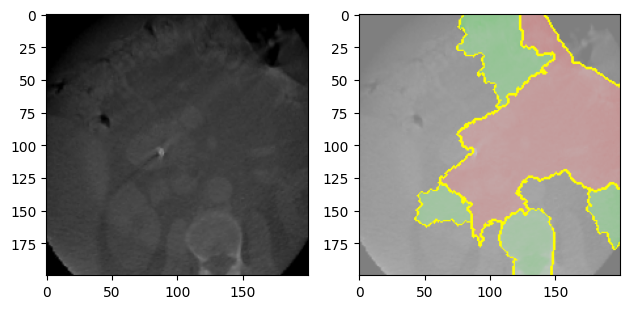

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[62], 62, exp14, 3, val_lab[62], val_preds[62])

In [ ]:
exp15 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


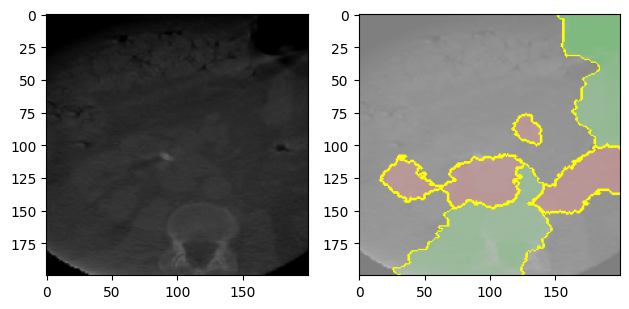

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[16], 16, exp15, 3, val_lab[16], val_preds[16])

In [ ]:
exp16 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


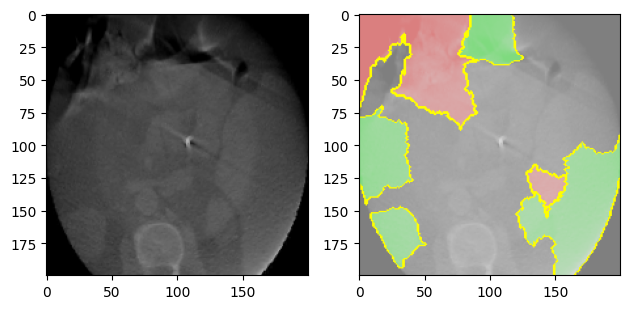

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[12], 12, exp16, 3, val_lab[12], val_preds[12])

In [ ]:
exp17 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


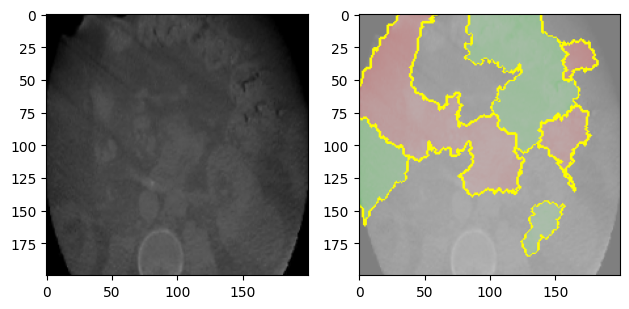

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[98], 98, exp17, 3, val_lab[98], val_preds[98])

In [ ]:
exp18 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


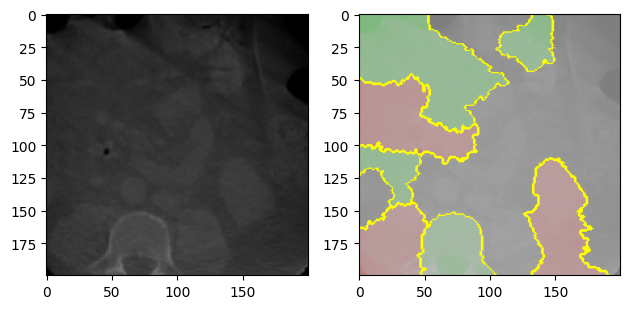

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[77], 77, exp18, 3, val_lab[77], val_preds[77])

In [ ]:
exp19 = lime_image.LimeImageExplainer()
#train_img[2], train_img[4]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


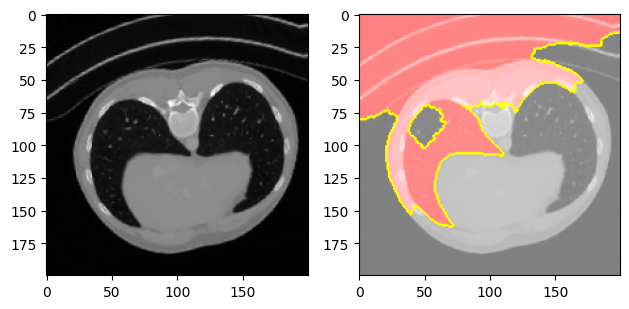

Correct Label: 0
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[47], 47, exp19, 3, val_lab[47], val_preds[47])

In [ ]:
interp = exp19.explain_instance(train_img[2].astype('double'), best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


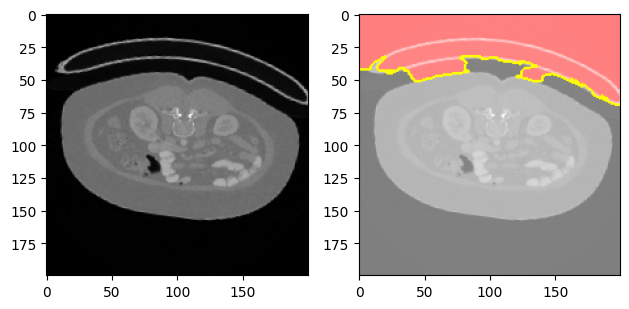

Correct Label: 0
Predicted Label: [0]


In [ ]:
  temp, mask = interp.get_image_and_mask(interp.top_labels[0],
                                                       positive_only=False, num_features=3,
                                                       hide_rest=False)
  limegraph = mark_boundaries(temp / 2 + 0.5, mask)
  
  plt.subplot(1, 2, 1)
  plt.imshow(train_img[2])
    
  plt.subplot(1, 2, 2)
  plt.imshow(limegraph)

  plt.tight_layout()
  plt.show()

  print(f'Correct Label: {train_lab[2]}')
  print(f'Predicted Label: {train_preds[2]}')

In [ ]:
exp20 = lime_image.LimeImageExplainer()
interp2 = exp20.explain_instance(train_img[4].astype('double'), best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


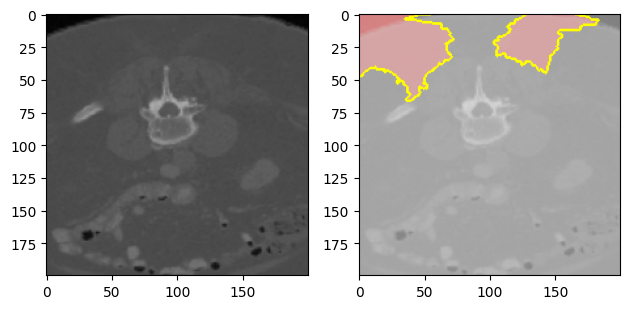

Correct Label: 0
Predicted Label: [0]


In [ ]:
  temp2, mask2 = interp2.get_image_and_mask(interp2.top_labels[0],
                                                       positive_only=False, num_features=3,
                                                       hide_rest=False)
  limegraph2 = mark_boundaries(temp2 / 2 + 0.5, mask2)
  
  plt.subplot(1, 2, 1)
  plt.imshow(train_img[4])
    
  plt.subplot(1, 2, 2)
  plt.imshow(limegraph2)

  plt.tight_layout()
  plt.show()

  print(f'Correct Label: {train_lab[4]}')
  print(f'Predicted Label: {train_preds[4]}')

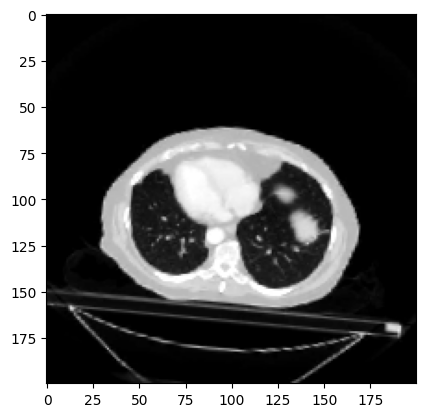

In [ ]:
plt.imshow(train_img[676])

In [ ]:
exp21 = lime_image.LimeImageExplainer()
interp21 = exp21.explain_instance(train_img[676].astype('double'), best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


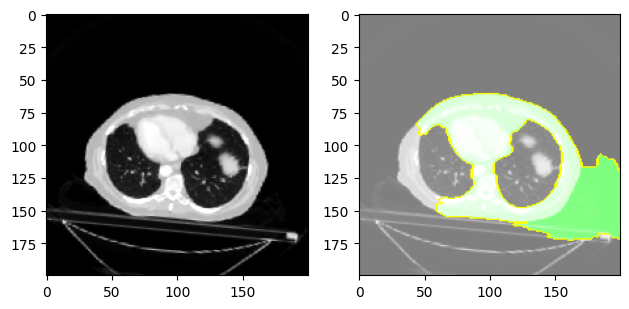

Correct Label: 1
Predicted Label: [1]


In [ ]:
  temp3, mask3 = interp21.get_image_and_mask(interp21.top_labels[0],
                                                       positive_only=False, num_features=3,
                                                       hide_rest=False)
  limegraph3 = mark_boundaries(temp3 / 2 + 0.5, mask3)
  
  plt.subplot(1, 2, 1)
  plt.imshow(train_img[676])
    
  plt.subplot(1, 2, 2)
  plt.imshow(limegraph3)

  plt.tight_layout()
  plt.show()

  print(f'Correct Label: {train_lab[676]}')
  print(f'Predicted Label: {train_preds[676]}')